In [1]:
import numpy as np
import pandas as pd

In [2]:
airports = pd.read_csv('airports.csv')
# Find rows with ident column equals to "VVTS"
tsn_df = airports[airports['ident'] == 'VVTS']

In [3]:
print(tsn_df['name'].values[0])
print(tsn_df['latitude_deg'].values[0])
print(tsn_df['longitude_deg'].values[0])

Tan Son Nhat International Airport
10.8188
106.652


In [4]:
# Convert latitude and longitude to UTM coordinates
import utm

tsn_lat = tsn_df['latitude_deg'].values[0]
tsn_lon = tsn_df['longitude_deg'].values[0]
tsn_coords = utm.from_latlon(tsn_lat, tsn_lon, force_zone_number=48, force_zone_letter='P')

In [5]:
# Convert from UTM to lat/lon
tma_topleft = utm.to_latlon(tsn_coords[0] - 150_000, tsn_coords[1] - 150_000, 48, 'P')
tma_bottomright = utm.to_latlon(tsn_coords[0] + 150_000, tsn_coords[1] + 150_000, 48, 'P')
print('Bottom Left: ', tma_topleft)
print('Top Right: ', tma_bottomright)

Bottom Left:  (9.466436452094468, 105.27879728970046)
Top Right:  (12.163066606744684, 108.03751911217596)


In [13]:
print('Bottom Left: ', tsn_coords[0] - 150_000, tsn_coords[1] - 150_000)
print('Top Right: ', tsn_coords[0] + 150_000, tsn_coords[1] + 150_000)

Bottom Left:  530603.5743816729 1046432.9997519567
Top Right:  830603.5743816729 1346432.9997519567


In [14]:
print('TSN Coordinates: ', tsn_coords)

TSN Coordinates:  (680603.5743816729, 1196432.9997519567, 48, 'P')


In [6]:
navaids = pd.read_csv('navaids.csv')
# Find all navaids within the TMA
tma_navaids = navaids[(navaids['latitude_deg'] >= tma_topleft[0]) & (navaids['latitude_deg'] <= tma_bottomright[0]) & (navaids['longitude_deg'] >= tma_topleft[1]) & (navaids['longitude_deg'] <= tma_bottomright[1])]
tma_navaids.head()

,id,filename,ident,name,type,frequency_khz,latitude_deg,longitude_deg,elevation_ft,iso_country,dme_frequency_khz,dme_channel,dme_latitude_deg,dme_longitude_deg,dme_elevation_ft,slaved_variation_deg,magnetic_variation_deg,usageType,power,associated_airport
173,85226,Anloc_NDB_VN,AC,Anloc,NDB,320,10.9392,107.188004,NaN,VN,NaN,NaN,NaN,NaN,NaN,NaN,-0.138,BOTH,MEDIUM,NaN
2020,87076,Can_Tho_NDB_VN,CT,Can Tho,NDB,420,10.0914,105.730003,NaN,VN,NaN,NaN,NaN,NaN,NaN,NaN,-0.102,BOTH,MEDIUM,VVCT
3426,88484,Tansonnhat_NDB_VN,GN,Tansonnhat,NDB,343,10.8269,106.678001,NaN,VN,NaN,NaN,NaN,NaN,NaN,NaN,-0.133,BOTH,MEDIUM,VVTS
3585,88644,Tansonnhat_NDB_VN,GV,Tansonnhat,NDB,375,10.8281,106.671997,NaN,VN,NaN,NaN,NaN,NaN,NaN,NaN,-0.133,BOTH,MEDIUM,VVTS
8470,93548,Tansonnhat_NDB_VN,SG,Tansonnhat,NDB,326,10.8549,106.751999,NaN,VN,NaN,NaN,NaN,NaN,NaN,NaN,-0.134,BOTH,MEDIUM,VVTS


In [7]:
runways = pd.read_csv('runways.csv')
# Find VVTS runways
tsn_runways = runways[runways['airport_ident'] == 'VVTS']
tsn_runways.head()

,id,airport_ref,airport_ident,length_ft,width_ft,surface,lighted,closed,le_ident,le_latitude_deg,le_longitude_deg,le_elevation_ft,le_heading_degT,le_displaced_threshold_ft,he_ident,he_latitude_deg,he_longitude_deg,he_elevation_ft,he_heading_degT,he_displaced_threshold_ft
41509,246162,26708,VVTS,10007.0,148.0,CON,1,0,07L,10.8150,106.637001,24.0,69.0,NaN,25R,10.8249,106.663002,32.0,249.0,NaN
41510,246161,26708,VVTS,12468.0,148.0,CON,1,0,07R,10.8115,106.637001,24.0,69.0,2431.0,25L,10.8237,106.669998,32.0,249.0,NaN


In [8]:
def get_le_he(tsn_runways, i, scale_factor = 5):
    le_lat, le_lon = tsn_runways['le_latitude_deg'].values[i], tsn_runways['le_longitude_deg'].values[i]
    he_lat, he_lon = tsn_runways['he_latitude_deg'].values[i], tsn_runways['he_longitude_deg'].values[i]
    # Convert latitude and longitude to UTM coordinates
    le_coords = utm.from_latlon(le_lat, le_lon, force_zone_number=48, force_zone_letter='P')
    he_coords = utm.from_latlon(he_lat, he_lon, force_zone_number=48, force_zone_letter='P')
    rw_length = np.sqrt((le_coords[0] - he_coords[0])**2 + (le_coords[1] - he_coords[1])**2)
    rw_length_new = rw_length * scale_factor # zoom up so that the runway is visible on the map
    he_coords_new = (he_coords[0] + (le_coords[0] - he_coords[0]) / rw_length * rw_length_new, he_coords[1] + (le_coords[1] - he_coords[1]) / rw_length * rw_length_new)
    # Convert from UTM to lat/lon
    le_coords_new = utm.to_latlon(le_coords[0], le_coords[1], 48, 'P')
    he_coords_new = utm.to_latlon(he_coords_new[0], he_coords_new[1], 48, 'P')
    return le_coords_new, he_coords_new

In [9]:
le_coords_new, he_coords_new = get_le_he(tsn_runways, 0)
le_coords_new2, he_coords_new2 = get_le_he(tsn_runways, 1)

In [10]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

from adjustText import adjust_text

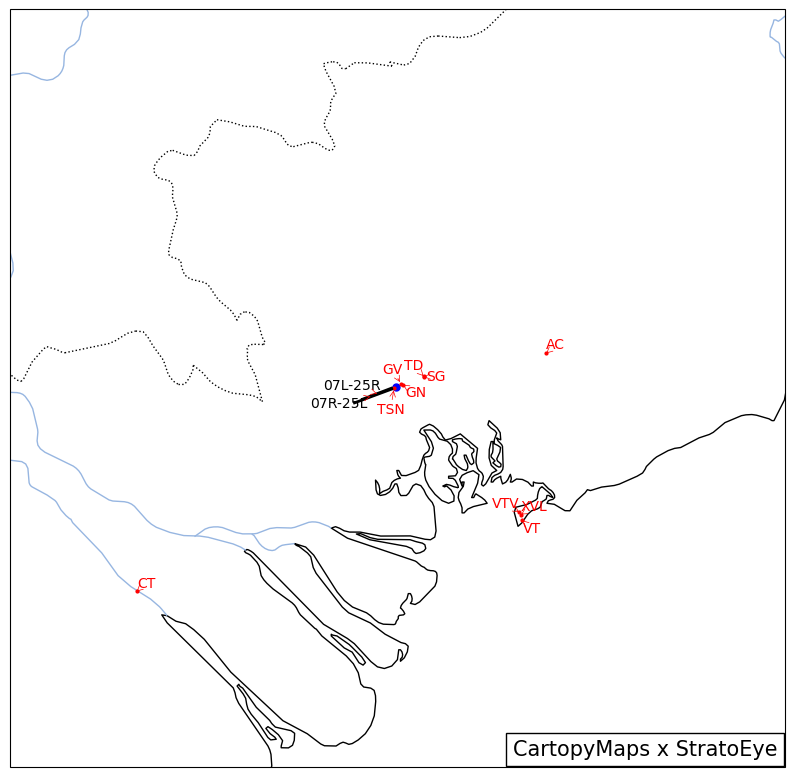

In [16]:
# Draw the map of the area near VVTS

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([tma_topleft[1], tma_bottomright[1], tma_topleft[0], tma_bottomright[0]], crs=ccrs.PlateCarree())

#ax.add_feature(cfeature.LAND)
#ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)

# Add the airport location
ax.plot(tsn_lon, tsn_lat, 'bo', markersize=5, transform=ccrs.PlateCarree())
# ax.text(tsn_lon + 0.05, tsn_lat + 0.05, 'VVTS', transform=ccrs.PlateCarree())

# Show all navaids from tma_navaids
ax.plot(tma_navaids['longitude_deg'], tma_navaids['latitude_deg'], 'ro', markersize=2, transform=ccrs.PlateCarree())
navaid_labels = []
for i, row in tma_navaids.iterrows():
    # Avoid overlapping labels
    navaid_labels.append(ax.text(row['longitude_deg'], row['latitude_deg'], row['ident'], c='r', transform=ccrs.PlateCarree()))

# Draw runways
ax.plot([le_coords_new[1], he_coords_new[1]], [le_coords_new[0], he_coords_new[0]], 'k-', lw=2, transform=ccrs.PlateCarree())
navaid_labels.append(ax.text((le_coords_new[1] + he_coords_new[1]) / 2, (le_coords_new[0] + he_coords_new[0]) / 2, tsn_runways['le_ident'].values[0] + '-' + tsn_runways['he_ident'].values[0], c='k', transform=ccrs.PlateCarree()))

ax.plot([le_coords_new2[1], he_coords_new2[1]], [le_coords_new2[0], he_coords_new2[0]], 'k-', lw=2, transform=ccrs.PlateCarree())
navaid_labels.append(ax.text((le_coords_new2[1] + he_coords_new2[1]) / 2, (le_coords_new2[0] + he_coords_new2[0]) / 2, tsn_runways['le_ident'].values[1] + '-' + tsn_runways['he_ident'].values[1], c='k', transform=ccrs.PlateCarree()))

# add text on the bottom right, with white background and black border
adjust_text(navaid_labels, only_move={'points':'y', 'texts':'y'}, arrowprops=dict(arrowstyle="->", color='r', lw=0.5))
ax.text(0.99, 0.01, 'CartopyMaps x StratoEye', verticalalignment='bottom', horizontalalignment='right', transform=ax.transAxes, color='black', fontsize=15, bbox=dict(facecolor='white', edgecolor='black', pad=5.0))

fig.savefig('vvts.png', dpi=300, bbox_inches='tight')

In [17]:
# Copy the image to ChatATC's assets folder
!cp vvts.png ../../public/vvts.png